# CS498PS - Lab 2: Filter Design and Usage

In [4]:
# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

def stft( input_sound, dft_size, hop_size, zero_pad, window):

    
    split_sound = np.asarray([input_sound[i : i+dft_size] for i in range(0, len(input_sound) - dft_size, hop_size)]).astype(float)
    split_sound *= window
    out = np.fft.rfft(split_sound, axis = 1)
   
    #Perform DFT on each frame
    
    return out

def istft( stft_output, dft_size, hop_size, zero_pad, window):

    out = np.fft.ifft(stft_output, axis = 1)
    
    x = np.zeros((out.shape))
    # Return reconstructed waveform
    print(out.shape)
    out = np.concatenate(out)
    return out


In [5]:
def normalize(arr, dtype = "PCM"): 
    if dtype == "PCM":
        return (2*(arr - np.min(arr)) / (np.max(arr) - np.min(arr) - 1)) * np.iinfo(np.float32).max

For this lab you will learn how to design some simple filters and how to apply them to solve some common audio problems. Python’s scipy.signal package has an extensive set of commands to help you design filters (firwin, firwin2, butter, cheby1, cheby2,  ellip, …), so there is no shortage of options.

## Part 1: When to use what 

There will be four cases to this part, each requiring a different type of filter to address a problem in a recording.  The input recordings are:

- ```case1.wav``` [https://drive.google.com/uc?export=download&id=1eTsDiXqqLQv3murPz25O54E89i3DL__d ] : A noise-corrupted speech signal. We want to eliminate the noise.
- ```case2.wav``` [https://drive.google.com/uc?export=download&id=1egd22CxPUe6sINIi0FPTbMfG4S_In2hT ] : Same as above, different type of noise. We want to remove the noise again.
- ```case3.wav``` [https://drive.google.com/uc?export=download&id=1eF-VOVWoT1rh1wAC06WT1ANusMKyDYSn ] : Bird songs during a thunderstorm. As a world renowned ornithologist you need to have a cleaner recording of the bird songs for further analysis.
- ```case4.wav``` [https://drive.google.com/uc?export=download&id=1eeizGhrBICf6pW5OXcbq7ChF4m2N6yIk ]: The signal that we require to extract here is a Morse code which is buried in environmental noise. Design a filter to bring out the beeps.

For each case do the following:
- Plot the spectrogram of the given sound and identify the problem
- Describe what kind of filter will address this problem and why
- Design an FIR filter using ```scipy.signal.firwin()``` and/or ```scipy.signal.firwin2()```
- Design an FIR filter using the formulas in my slides (i.e. do not use ```scipy.signal```)
- Design an IIR Butterworth filter using ```scipy.signal```'s routines
- Show a plot comparing the response of all the filters (hint: ```scipy.signal.freqz```)
- Plot spectrograms of the filtered recordings and compare with the input to show that it fixed the problem
- Play the filtered sounds so that we can hear how well it works

Make some observations on how the results differ between an FIR and IIR filter and try to find the best possible filter size/type/parameters to produce the best result. Show results under various parameters (e.g. filter length) and make some plots that demonstrate the effects of these parameters. Most importantly, try to get a sense of how these design choices impact audible quality. Being able to listen at a sound and identify what’s wrong and how to fix it is a big part of audio processing.

Hint: To apply an FIR filter you can use ```scipy.signal.convolve```, to apply an IIR filter (or an FIR) you can use ```scipy,signal.lfilter```.


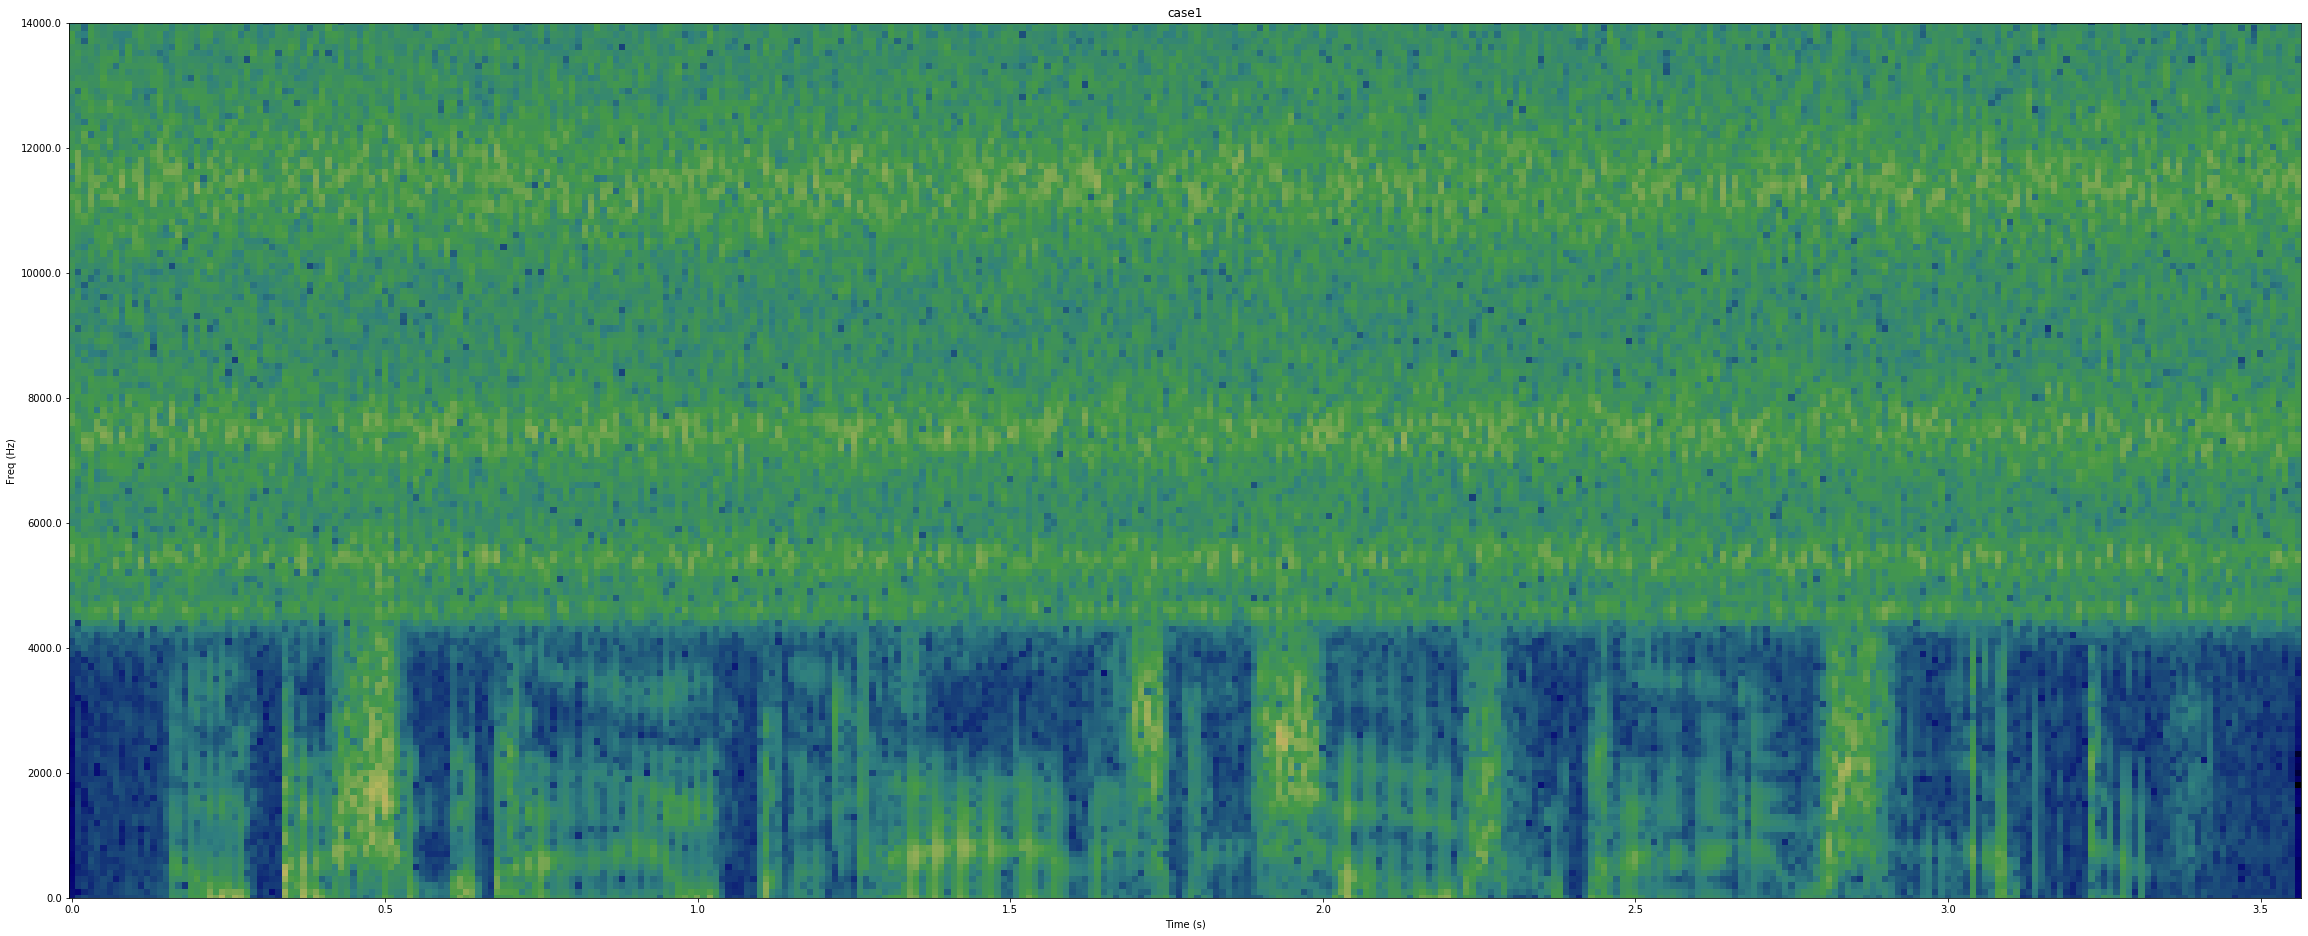

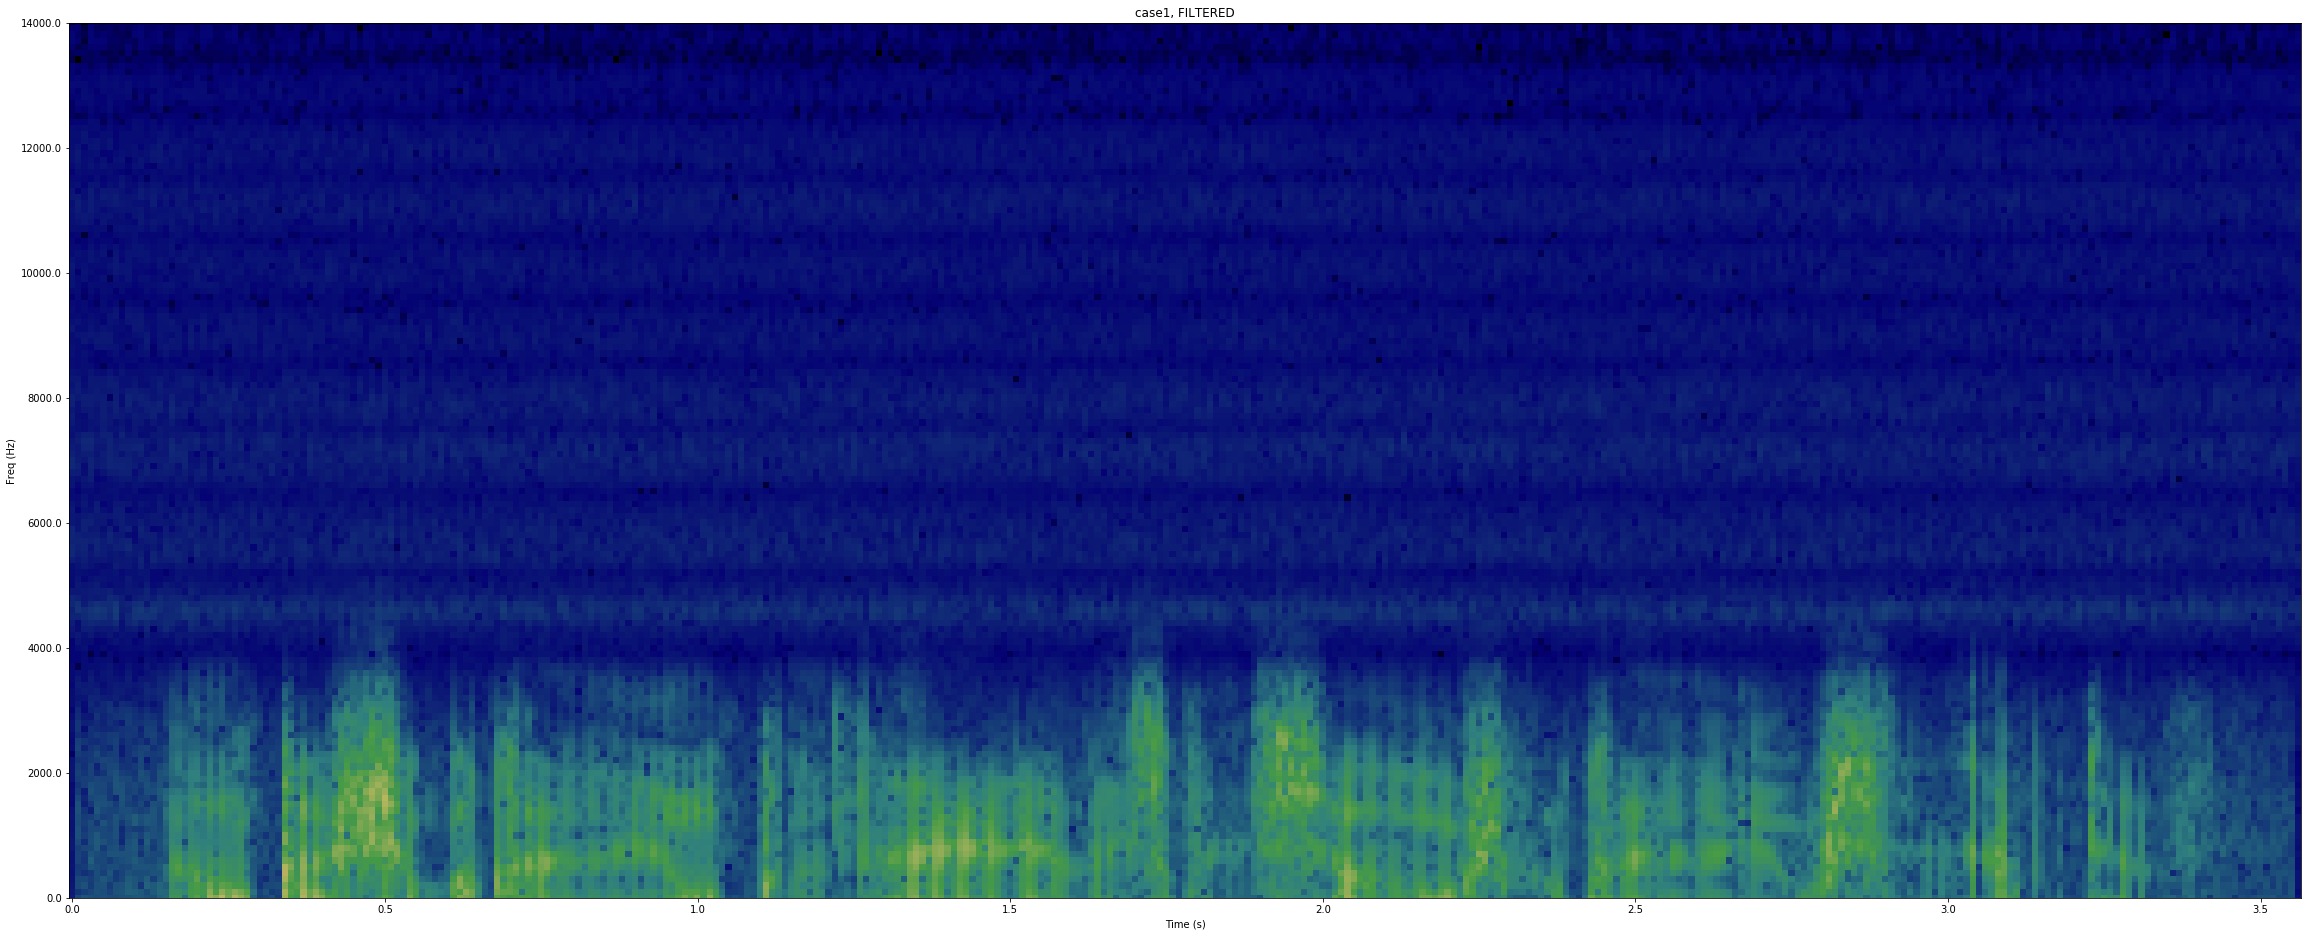

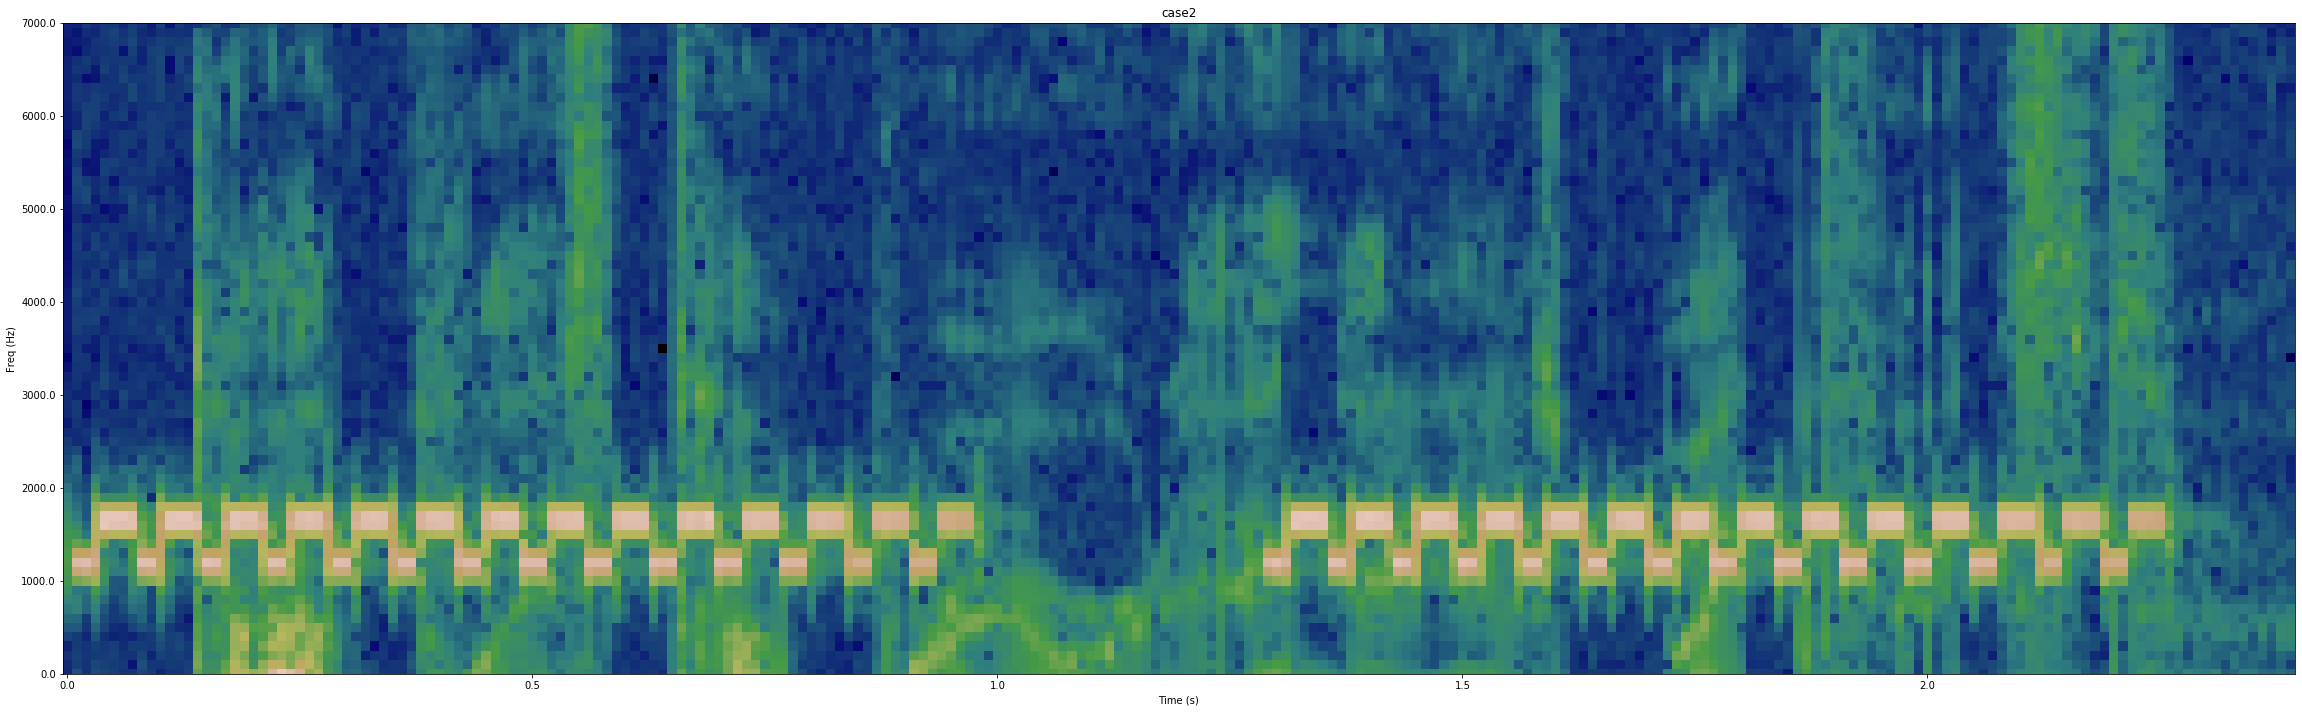

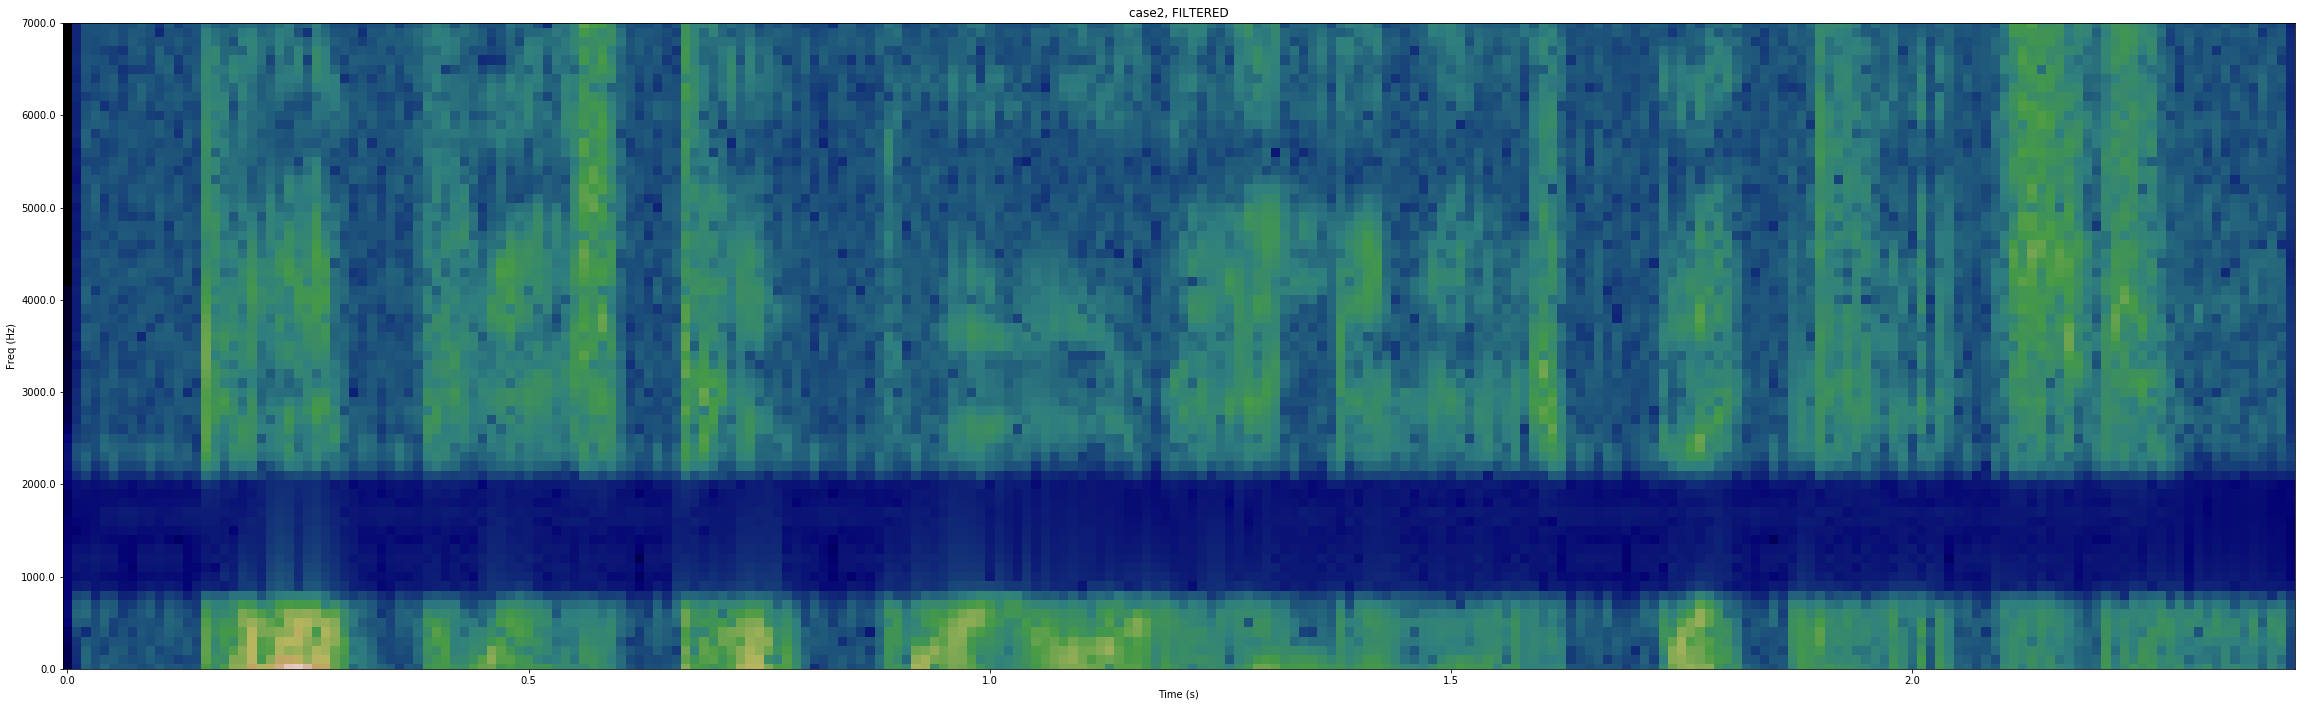

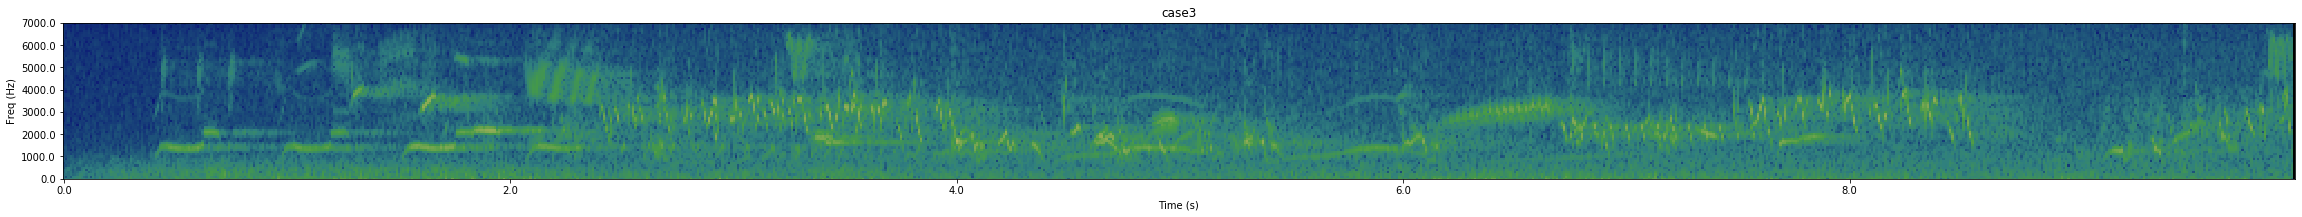

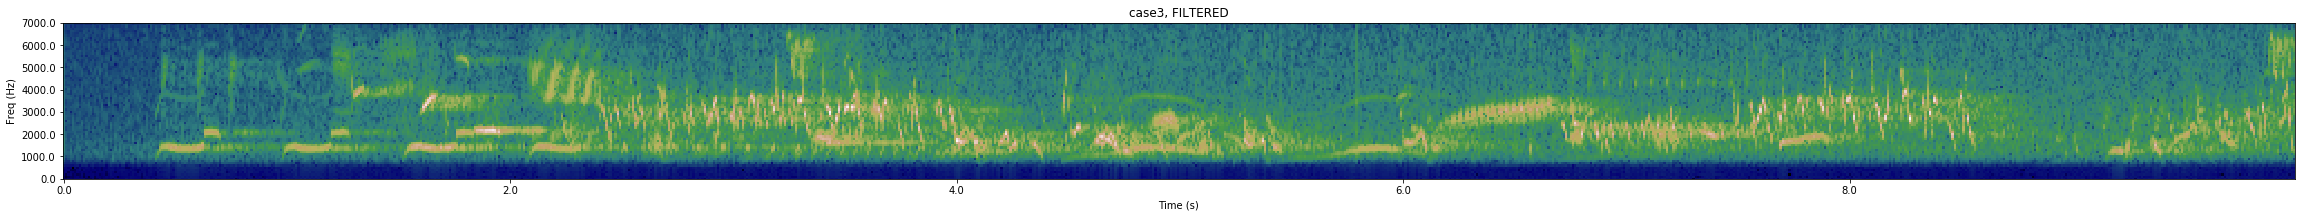

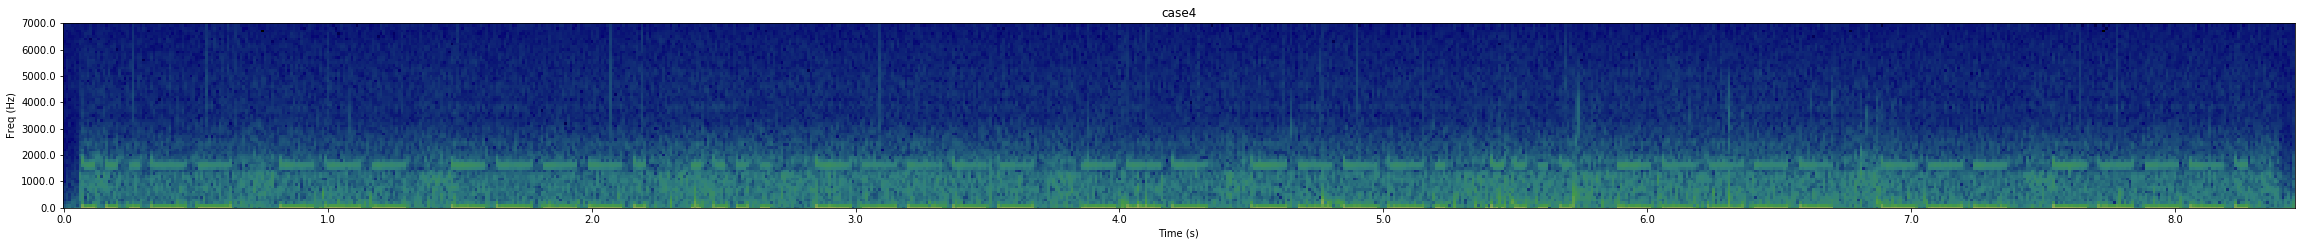

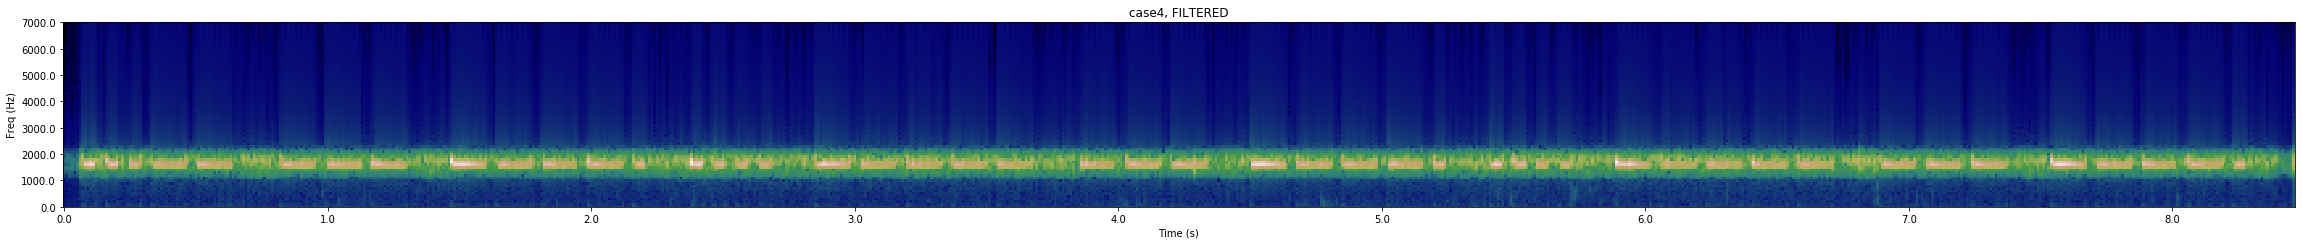

In [6]:
# Load the sound, play it, and plot it's spectrogram
def analyze_sound(signal, dft_size, hop_size, zero_pad, window, sr, name = ""):
    out = stft(signal, dft_size, hop_size, 0, np.blackman(dft_size))
    
    f = np.zeros((dft_size // 2, (len(signal) // hop_size)))
    for i in range(0, len(signal) - dft_size, hop_size):
        amps = np.abs(np.fft.rfft(signal[i : i+ dft_size]*window, n=dft_size+zero_pad))
        idx = i // hop_size
        for y in range(dft_size // 2):
            f[y][idx] = amps[y]
    plt.figure(figsize=(40, 40))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(f[::-1]**.2, cmap="gist_earth")
    freq_res = sr / dft_size
    time_res = hop_size / sr
    xticks = ax.get_xticks()[1:-1]
    yticks = ax.get_yticks()[1:-1]
    plt.xticks(xticks, np.round(xticks * time_res , decimals=1))
    plt.yticks(yticks, np.round((yticks * freq_res)[::-1]))
    plt.xlabel("Time (s)")
    plt.ylabel("Freq (Hz)")
    plt.title(name)
    sound(signal, rate=sr, label=name)
    
#CASE1*******************************
c1sr, case1 = wavfile.read("data/case1.wav")
analyze_sound(case1, c1sr//100, c1sr//100, 0, np.blackman(c1sr//100), c1sr, "case1")
case1_filt = signal.firwin(32, 4000, fs=c1sr, window="hamming")

new_case1 = signal.convolve(case1, case1_filt)
analyze_sound(new_case1, c1sr//100, c1sr//100, 0, np.blackman(c1sr//100), c1sr, "case1, FILTERED")
#*************************************

#CASE2********************************
c2sr, case2 = wavfile.read("data/case2.wav")
analyze_sound(case2, c2sr//100, c2sr//100, 0, np.blackman(c2sr//100), c2sr, "case2")
case2_filt = signal.firwin(377, (1500, 3200), fs=c2sr, window="blackman", )

new_case2 = signal.convolve(case2, case2_filt)
analyze_sound(new_case2, c2sr//100, c2sr//100, 0, np.blackman(c2sr//100), c2sr, "case2, FILTERED")
#*************************************

#CASE3********************************
c3sr, case3 = wavfile.read("data/case3.wav")
analyze_sound(case3, c3sr//100, c3sr//100, 0, np.blackman(c3sr//100), c3sr, "case3")
case3_filt = signal.firwin(93, (1,2000), fs=c3sr, window="blackman")

new_case3 = signal.convolve(case3, case3_filt)
analyze_sound(new_case3, c3sr//100, c3sr//100, 0, np.blackman(c3sr//100), c3sr, "case3, FILTERED")
#*************************************

#CASE4********************************
c4sr, case4 = wavfile.read("data/case4.wav")
analyze_sound(case4, c4sr//100, c4sr//100, 0, np.blackman(c4sr//100), c4sr, "case4")
case4_filt = signal.firwin(93, (1, 2500, 2700), fs=c4sr, window="blackman")

new_case4 = signal.convolve(case4, case4_filt)
analyze_sound(new_case4, c4sr//100, c4sr//100, 0, np.blackman(c4sr//100), c4sr, "case4, FILTERED")
#*************************************

## Part 2. Designing a simple equalizer

For this part we will design a simple graphic equalizer. We will do so using a more straightforward approach as opposed to a bank of filters as discussed in class.

We want to make an equalizer which contains six bands with center frequencies at 100Hz, 200Hz, 400Hz, 800Hz, 1600Hz and 3200Hz. Your equalizer function will take two inputs, one for the input sound and a 6-element gain vector that will indicate how much to boost or suppress each frequency band. Use the ```scipy.signal.firwin2``` function to design a filter that has the desired characteristics. For various settings of the gain vector, use the ```scipy.signal.freqz``` command to plot the response of the filter and verify that it behaves as indicated. Experiment with various filter lengths and see which works best.

Once you figure that out, design a graphic equalizer with as many bands as you like (and arbitrary center frequencies as well), and use it to solve the problems in part 1 again. The only thing that should be different in the EQ for each recording should be the gains for each band. Play the output sounds, and show the spectrograms, see how they compare with your previous solutions.

Optional extra credit (+1pt): Use ipywidgets to make intective sliders and process an audio stream and play it from the speakers in real-time (either from mic input, or just stream audio from disk).

[0.0, 1.0, 0.5, 0.5, 0.5, 0.4, 0.2, 0.0, 0.0]


[0.0, 1.0, 0.5, 0.5, 0.5, 0.0, 0.0, 1.0, 0.0]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0]


NotImplementedError: 

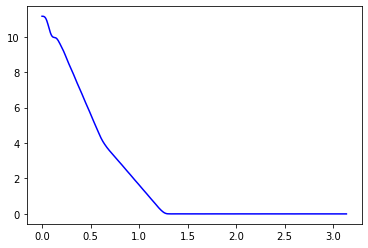

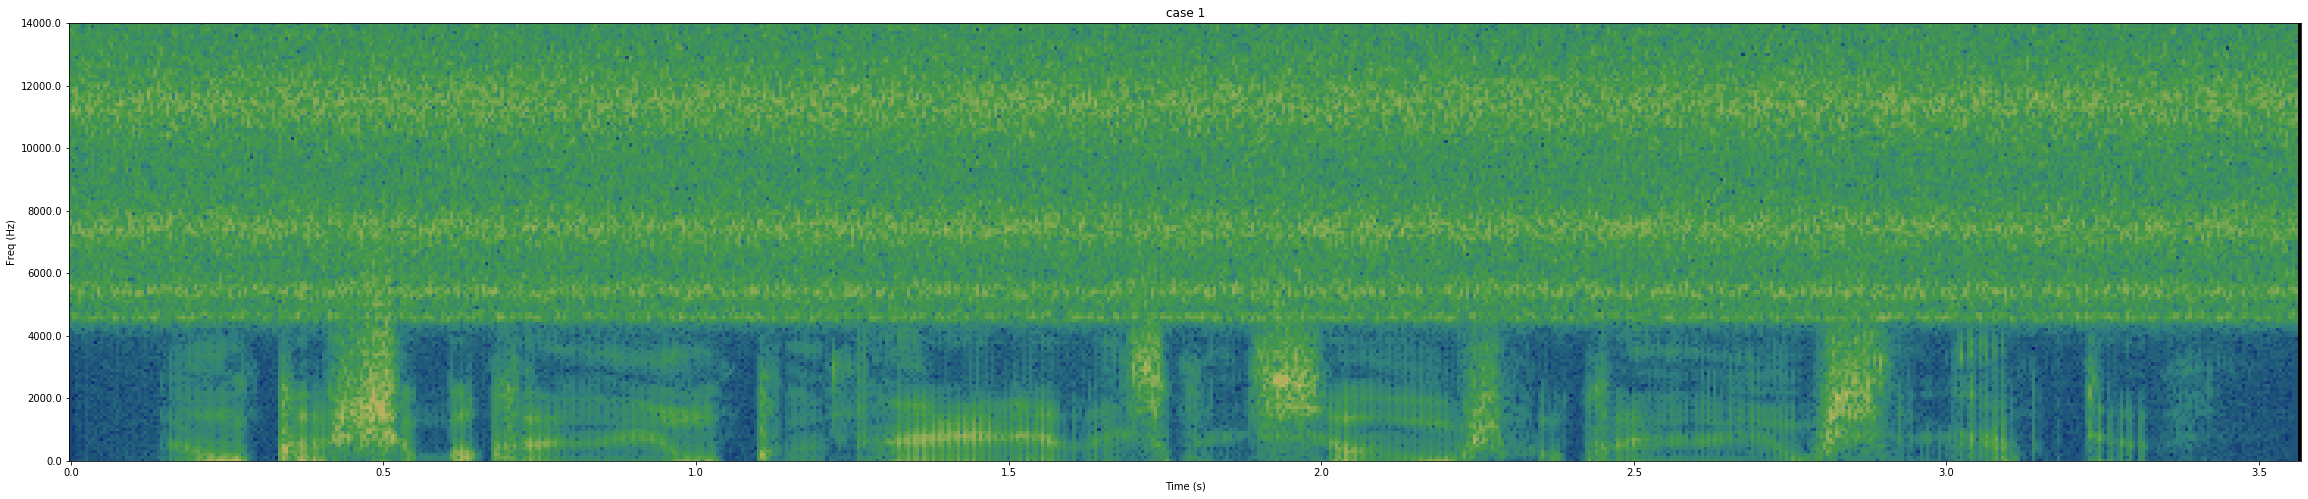

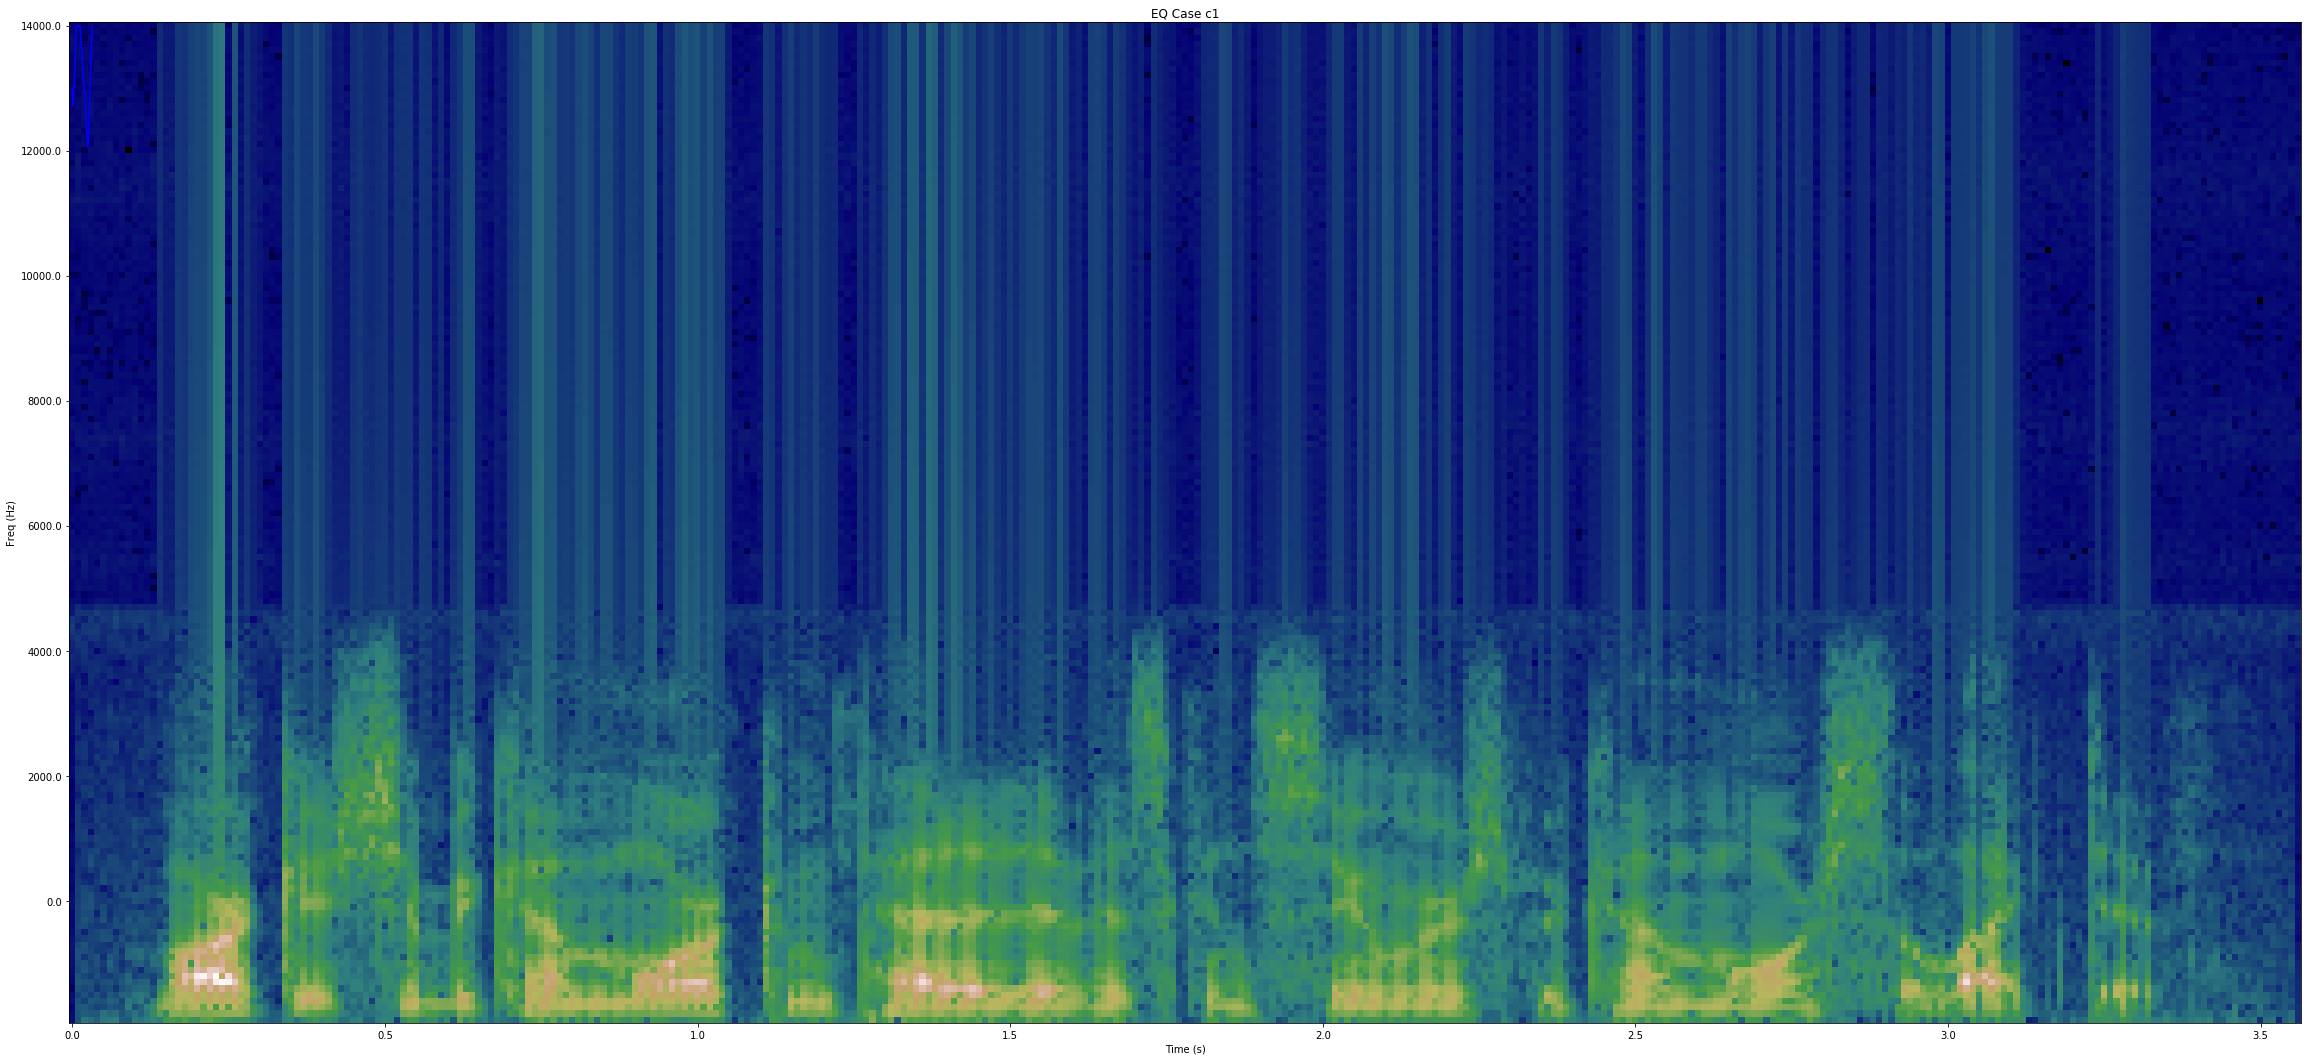

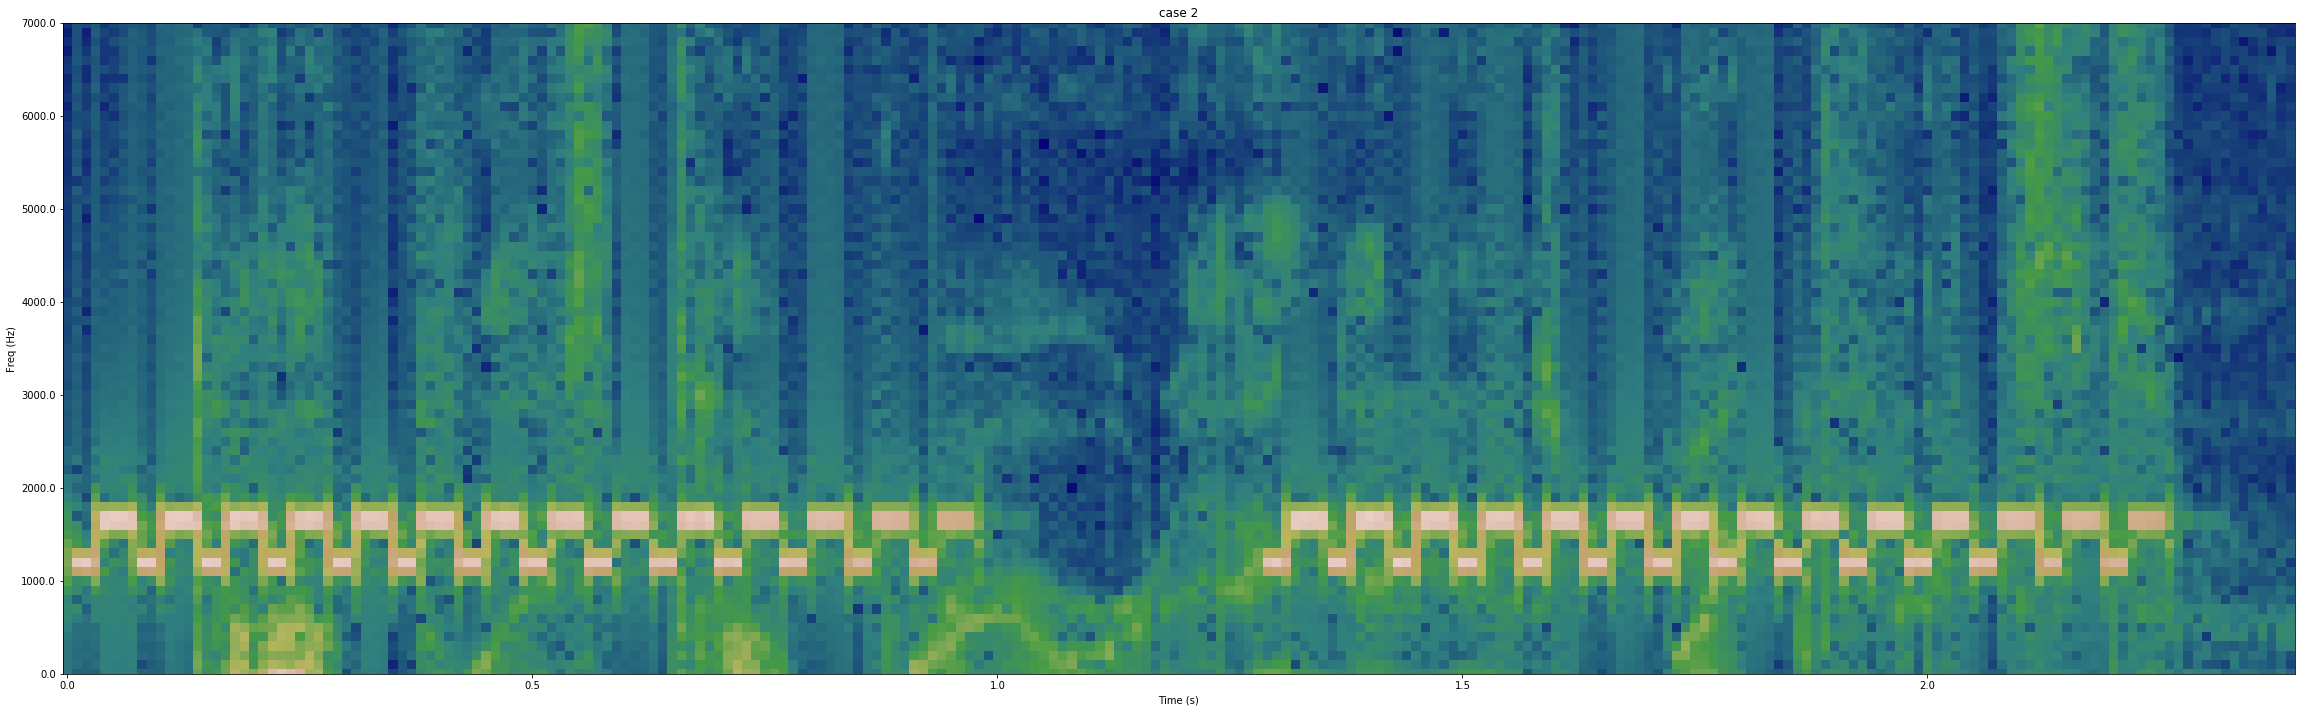

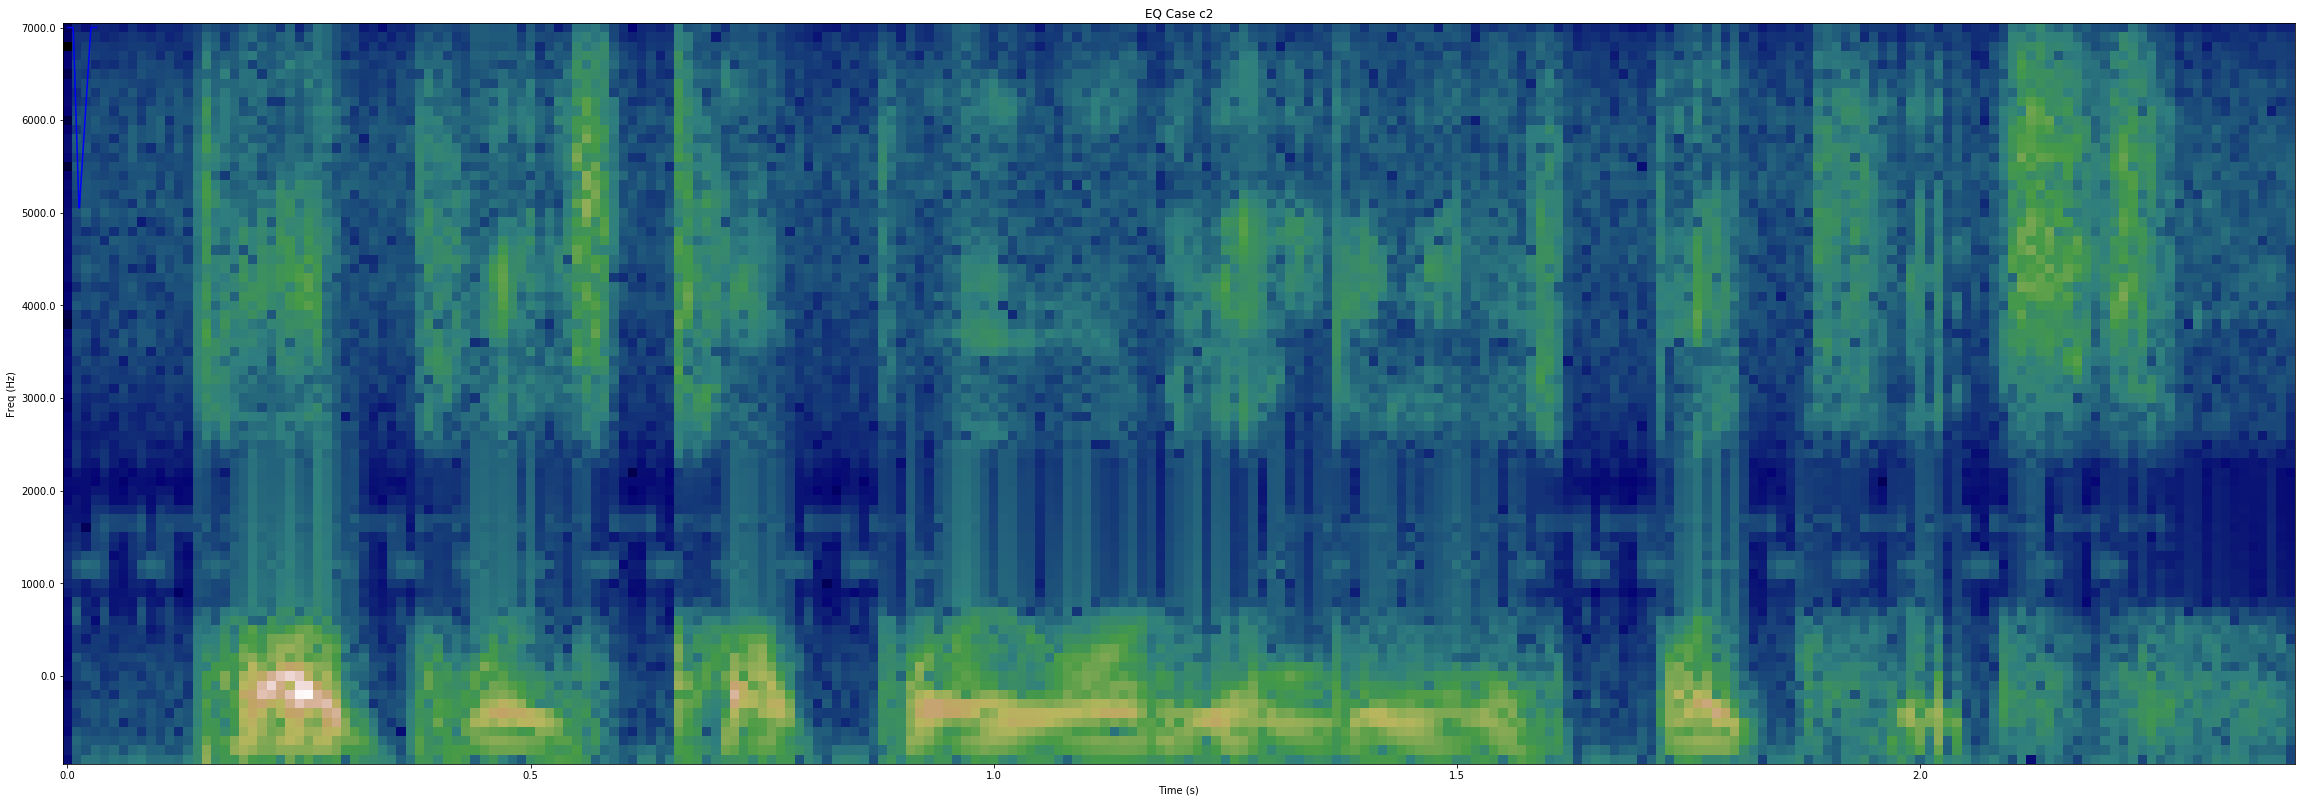

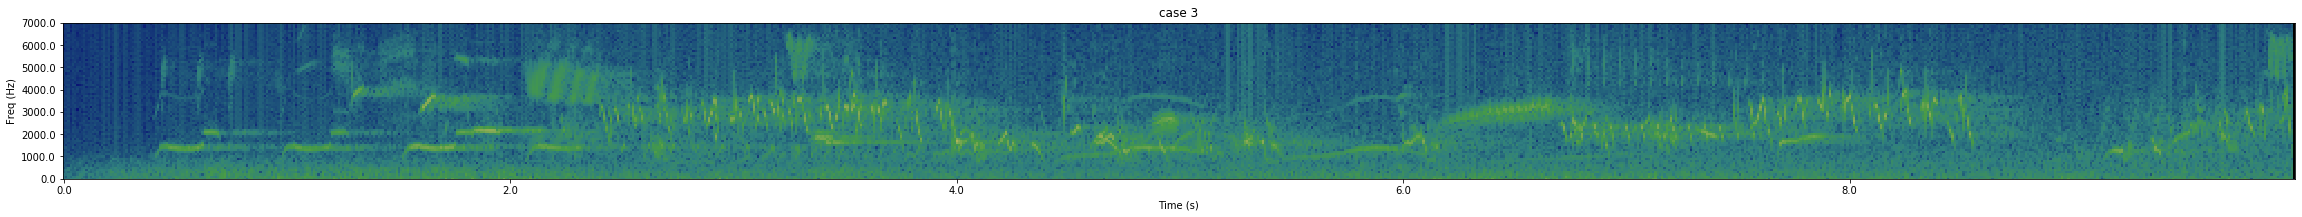

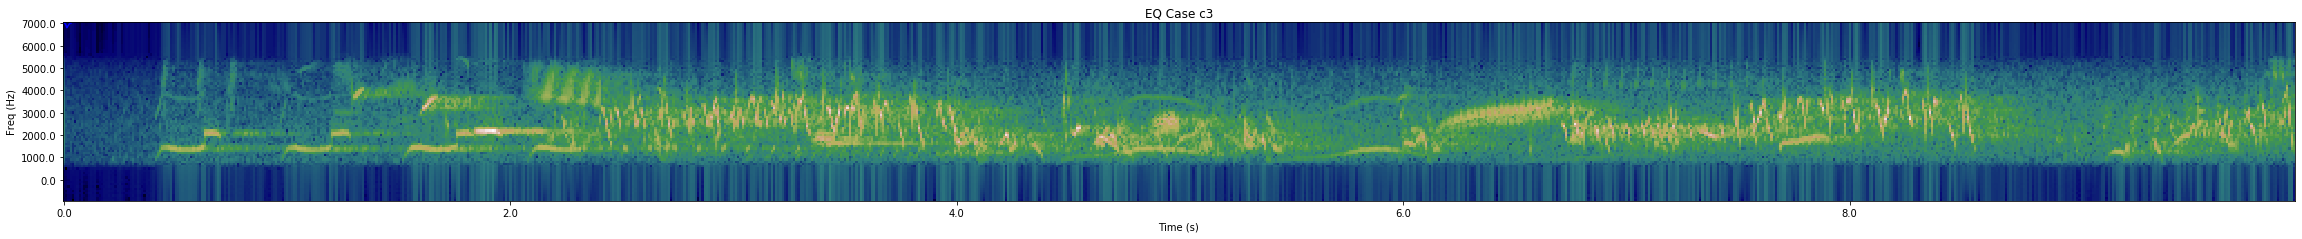

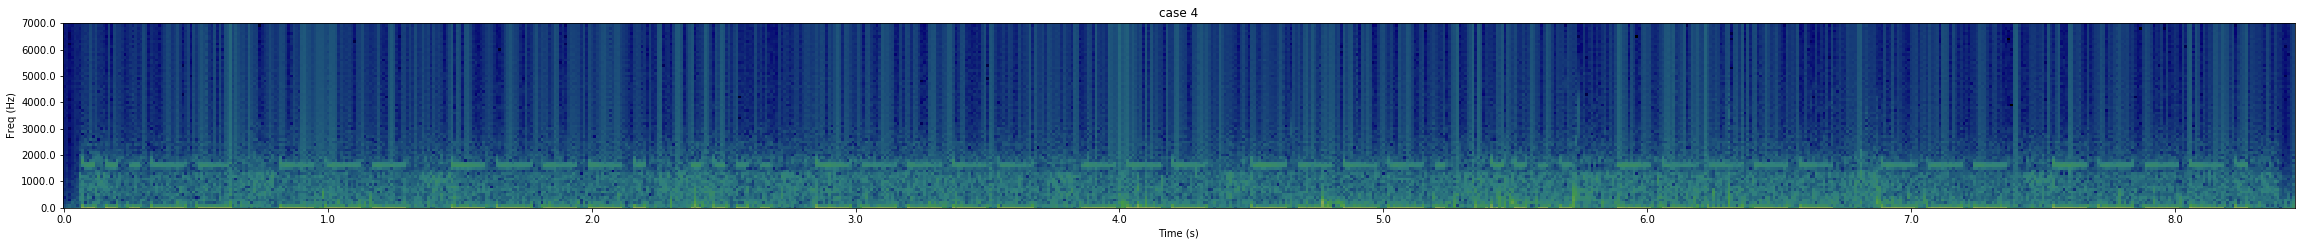

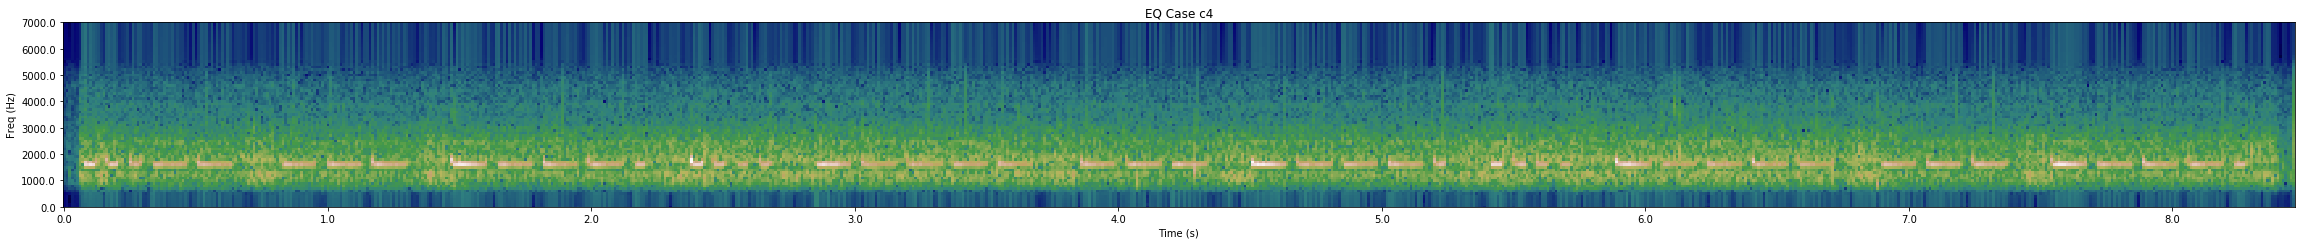

In [34]:
# Design an equalizer function
def equalizer( input_sound, gains, sr):
    x = input_sound
    bands = [0, 100, 200, 400, 800, 1600, 3200, 6400, sr/2]
    g = [None] * (len(gains))
    g[0] = 0.0
    g[len(g) - 1] = 0.0
    g[1:len(g)-1] = gains
    print(g)
    filt = signal.firwin2(150, bands, g, nyq = sr/2)
    
    w, h = signal.freqz(filt)
    plt.plot(w, 20 * abs(h), 'b')
    return signal.convolve(input_sound, filt)
# Show its response with various gain settings

c1sr, case1 = wavfile.read("data/case1.wav")
eq_case1 = equalizer(case1, [1.0, 0.5, 0.5, 0.5, 0.4, 0.2, 0.0], c1sr)
analyze_sound(case1, c1sr //100, c3sr //100, 0, np.hamming(c1sr//100), c1sr, name="case 1")
analyze_sound(eq_case1, c1sr //100, c1sr //100, 0, np.hamming(c1sr//100), c1sr, name="EQ Case c1")

c2sr, case2 = wavfile.read("data/case2.wav")
eq_case2 = equalizer(case2, [1.0, 0.5, 0.5, 0.5, 0.0, 0.0, 1.0], c2sr)
analyze_sound(case2, c2sr //100, c2sr //100, 0, np.hamming(c2sr//100), c2sr, name="case 2")
analyze_sound(eq_case2, c2sr //100, c2sr //100, 0, np.hamming(c2sr//100), c2sr, name="EQ Case c2")

c3sr, case3 = wavfile.read("data/case3.wav")
eq_case3 = equalizer(case3, [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], c3sr)
analyze_sound(case3, c3sr //100, c3sr //100, 0, np.hamming(c3sr//100), c3sr, name="case 3")
analyze_sound(eq_case3, c3sr //100, c3sr //100, 0, np.hamming(c3sr//100), c3sr, name="EQ Case c3")

c4sr, case4 = wavfile.read("data/case4.wav")
eq_case4 = equalizer(case4, [0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0], c4sr)
analyze_sound(case4, c4sr //100, c4sr //100, 0, np.hamming(c4sr//100), c4sr, name="case 4")
analyze_sound(eq_case4, c4sr //100, c4sr //100, 0, np.hamming(c4sr//100), c4sr, name="EQ Case c4")

# Show how it can denoise the examples in part 1
# YOUR CODE HERE
raise NotImplementedError()